### ImageNet预训练图像分类模型预测单张图像

#### 使用ImageNet预训练图像分类模型，对单张图像文件执行前向预测

## 导入基础工具包

In [1]:
import os

import cv2

import pandas as pd
import numpy as np

import torch

import matplotlib.pyplot as plt
%matplotlib inline

### 计算设备

In [2]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
print('device', device)

device cuda:0


### 载入预训练图像分类模型

In [4]:
from torchvision import models

In [5]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [8]:
# 载入预训练图像分类模型

model = models.resnet18(pretrained=True) 

# model = models.resnet152(pretrained=True)

In [9]:
model = model.eval()
model = model.to(device)

### 图像预处理

In [10]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化  对测试集的图像也好，视频帧也好，摄像头的实时画面也好，用户新上传的图像也好，都经过这四步骤。Resize-把
#任何一张图resize成256*256的，再在中间截成224*224的，再转换成pytorch的张量Tensor，接下来再对RGB三通道做归一化，减去均值除以标准差。均值就是RGB红绿蓝三通道
#的均值，标准差也是，这6个数就是约定俗成的，是从ImageNet海量的图像数据中得到的均值和标准差。把任何一张新来的图都这样处理。
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 载入一张测试图像

In [14]:
img_path = '/home/featurize/2-Pytorch-ImageNet Pre-practice/test_img/test_BoBo.jpg'

In [15]:
# 用 pillow 载入
from PIL import Image
img_pil = Image.open(img_path)

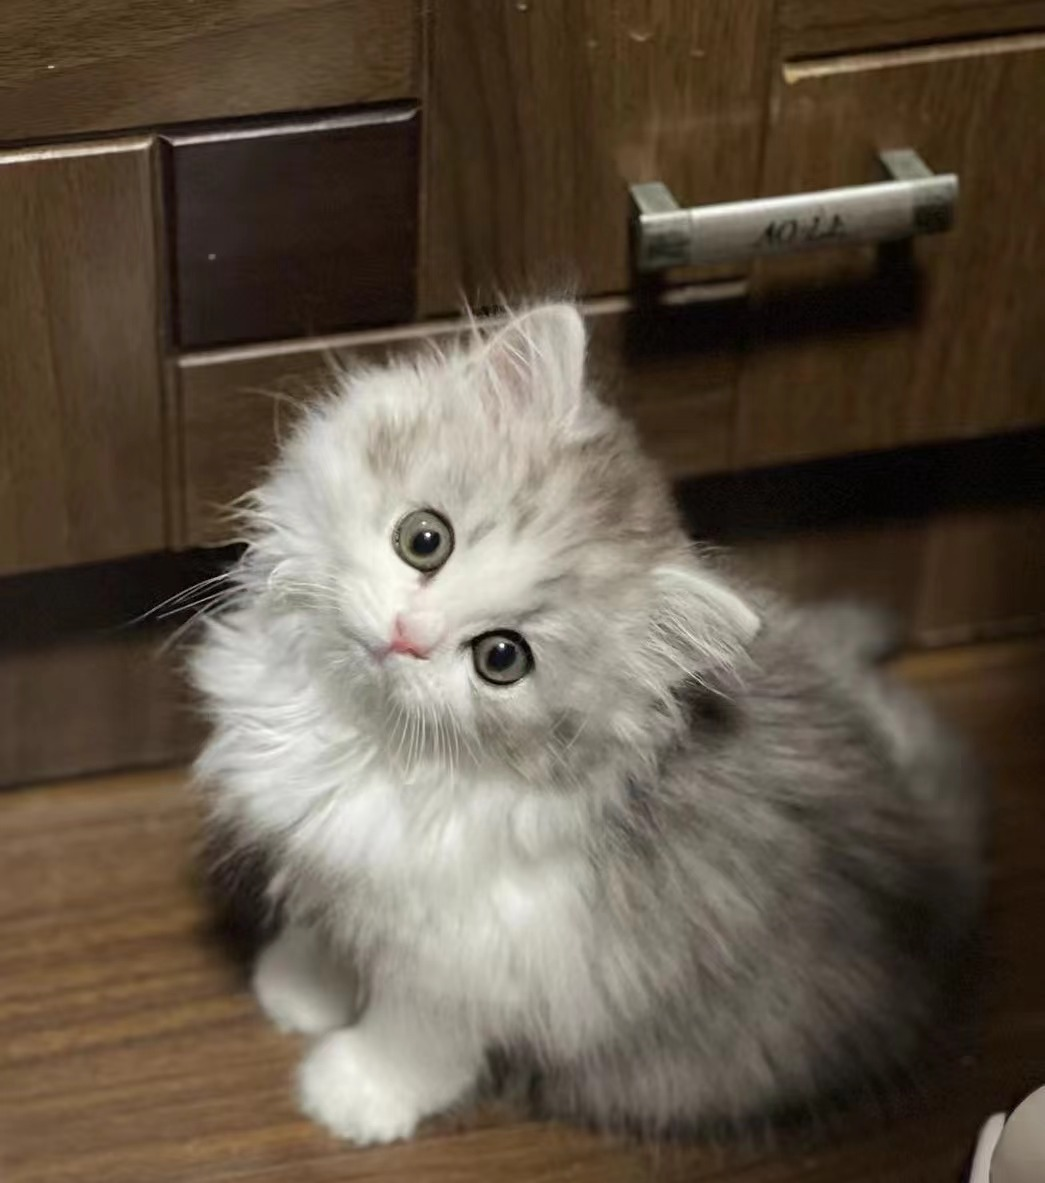

In [16]:
img_pil

In [17]:
np.array(img_pil).shape  #转成numpy array

(1183, 1045, 3)

### 执行图像分类预测

In [18]:
input_img = test_transform(img_pil) # 预处理

In [19]:
input_img.shape

torch.Size([3, 224, 224])

In [20]:
input_img = input_img.unsqueeze(0).to(device)   #用unsqueeze（0）函数，把它变成“1张，3通道，224*224的图，因为pytorch的数据模型必须这个数据维度”

In [21]:
input_img.shape

torch.Size([1, 3, 224, 224])

In [22]:
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_img) 

In [23]:
pred_logits.shape

torch.Size([1, 1000])

In [24]:
# pred_logits

In [25]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算 转成了0~1之间的概率，并且求和为1，置信度

In [26]:
pred_softmax.shape

torch.Size([1, 1000])

In [27]:
# pred_softmax

### 预测结果分析

#### 各类别置信度柱状图

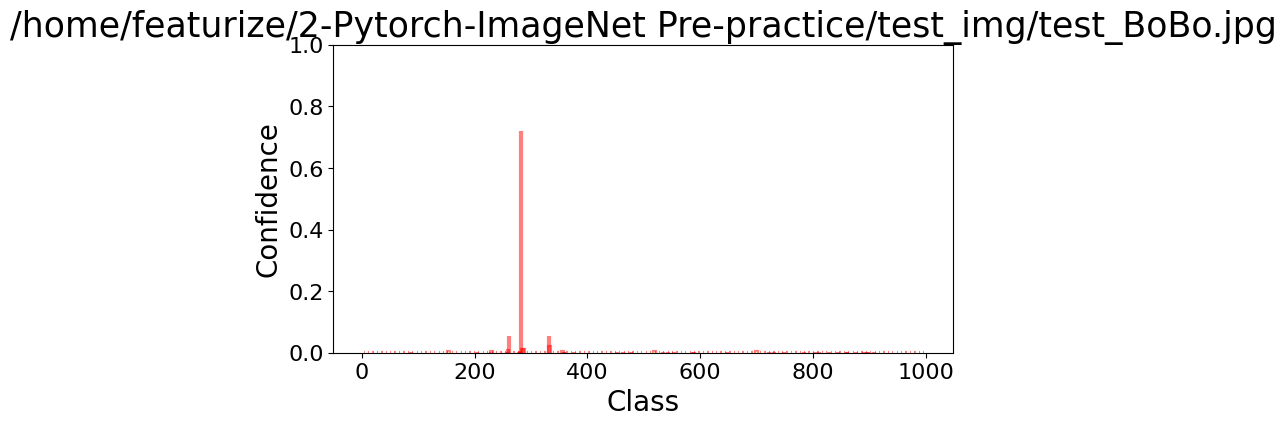

In [28]:
plt.figure(figsize=(8,4))

x = range(1000)
y = pred_softmax.cpu().detach().numpy()[0]

ax = plt.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)
plt.ylim([0, 1.0]) # y轴取值范围
# plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
plt.tick_params(labelsize=16) # 坐标文字大小
plt.title(img_path, fontsize=25)

plt.show()

### 取置信度最大的前N个结果

In [29]:
n = 10
top_n = torch.topk(pred_softmax, n)

In [30]:
top_n  #得到前10个置信度最高结果的id和置信度

torch.return_types.topk(
values=tensor([[0.7204, 0.0553, 0.0551, 0.0181, 0.0133, 0.0098, 0.0095, 0.0069, 0.0037,
         0.0030]], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[283, 261, 332, 333, 259, 285, 287, 281, 154, 845]], device='cuda:0'))

In [31]:
# 解析出类别
pred_ids = top_n[1].cpu().detach().numpy().squeeze()

In [32]:
pred_ids

array([283, 261, 332, 333, 259, 285, 287, 281, 154, 845])

In [33]:
# 解析出置信度
confs = top_n[0].cpu().detach().numpy().squeeze()

In [34]:
confs

array([0.72040546, 0.05527922, 0.05513218, 0.01810496, 0.01326575,
       0.00977715, 0.00947651, 0.00692516, 0.0037218 , 0.00301522],
      dtype=float32)

### 载入ImageNet 1000图像分类标签

In [35]:
df = pd.read_csv('imagenet_class_index.csv')

In [36]:
df

,ID,class,wordnet,Chinese
0,0,tench,n01440764,丁鲷
1,1,goldfish,n01443537,金鱼
2,2,great_white_shark,n01484850,大白鲨
3,3,tiger_shark,n01491361,虎鲨
4,4,hammerhead,n01494475,锤头鲨
...,...,...,...,...
995,995,earthstar,n13044778,地星（菌类）
996,996,hen-of-the-woods,n13052670,多叶奇果菌
997,997,bolete,n13054560,牛肝菌
998,998,ear,n13133613,玉米穗


In [37]:
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = [row['wordnet'], row['class']]

In [38]:
# idx_to_labels  #转成python的字典，键值对

### 图像分类结果写在原图上

In [39]:
## 用 opencv 载入原图
img_bgr = cv2.imread(img_path)

In [40]:
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]][1] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence)
    print(text)
    
    # !图片，添加的文字，左上角坐标，字体，字号，bgr颜色，线宽  写在原图上，指定位置横纵坐标，字体，线宽
    img_bgr = cv2.putText(img_bgr, text, (25, 50 + 40 * i), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 0, 255), 3)

Persian_cat     72.0405
keeshond        5.5279
Angora          5.5132
hamster         1.8105
Pomeranian      1.3266
Egyptian_cat    0.9777
lynx            0.9477
tabby           0.6925
Pekinese        0.3722
syringe         0.3015


In [45]:
# 保存图像
cv2.imwrite('output/img_pred.jpg', img_bgr)

True

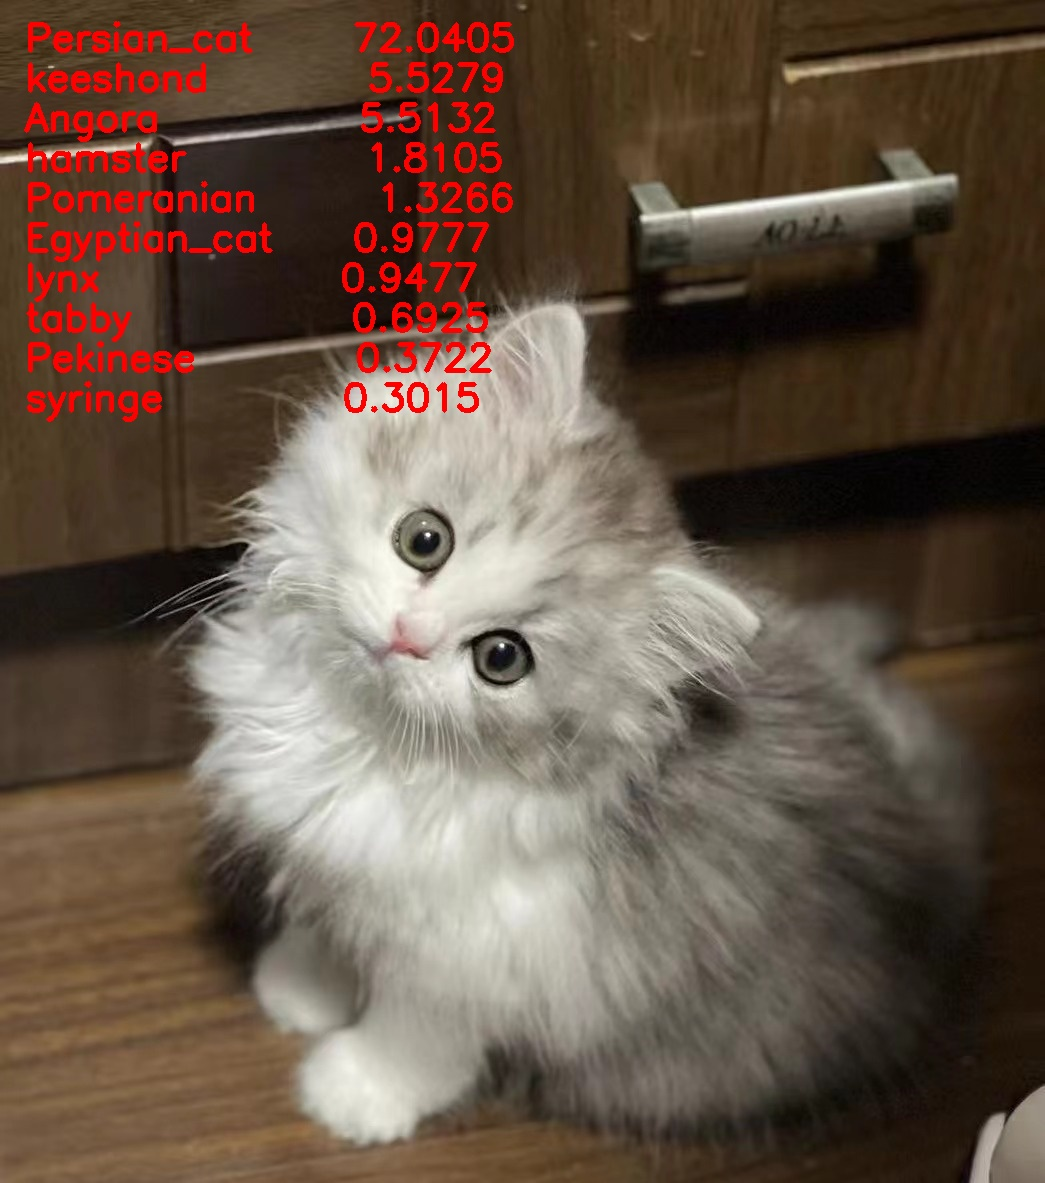

In [46]:
# 载入预测结果图像
img_pred = Image.open('output/img_pred.jpg')
img_pred

### 图像和柱状图一起显示

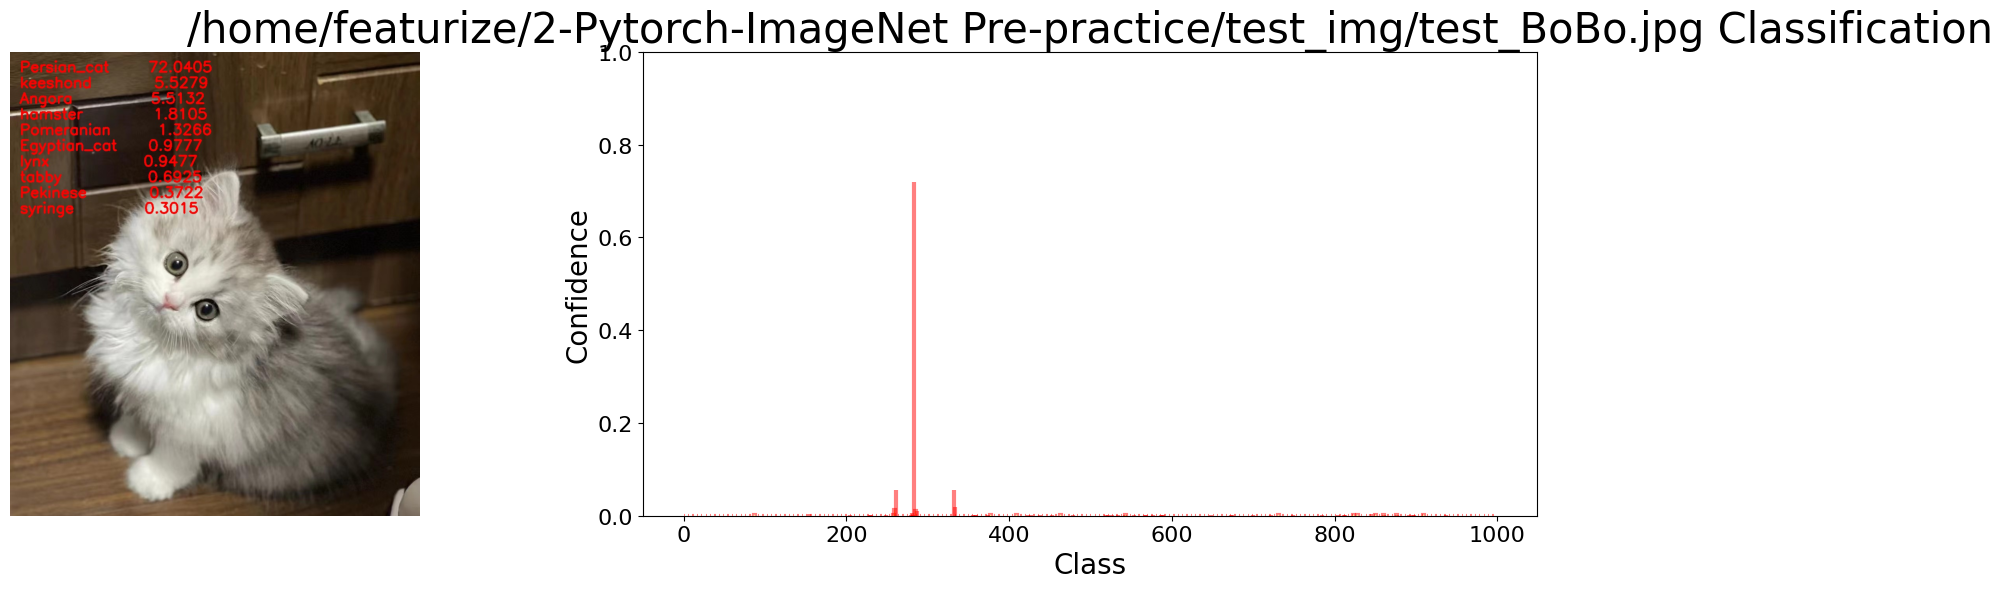

In [47]:
fig = plt.figure(figsize=(18,6))

# 绘制左图-预测图
ax1 = plt.subplot(1,2,1)
ax1.imshow(img_pred)
ax1.axis('off')

# 绘制右图-柱状图
ax2 = plt.subplot(1,2,2)
x = df['ID']
y = pred_softmax.cpu().detach().numpy()[0]
ax2.bar(x, y, alpha=0.5, width=0.3, color='yellow', edgecolor='red', lw=3)

plt.ylim([0, 1.0]) # y轴取值范围
plt.title('{} Classification'.format(img_path), fontsize=30)
plt.xlabel('Class', fontsize=20)
plt.ylabel('Confidence', fontsize=20)
ax2.tick_params(labelsize=16) # 坐标文字大小

plt.tight_layout()
fig.savefig('output/预测图+柱状图.jpg')

### 预测结果表格输出

In [49]:
pred_df = pd.DataFrame() # 预测结果表格
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]][1] # 获取类别名称
    label_idx = int(pred_ids[i]) # 获取类别号
    wordnet = idx_to_labels[pred_ids[i]][0] # 获取 WordNet
    confidence = confs[i] * 100 # 获取置信度
    pred_df = pred_df._append({'Class':class_name, 'Class_ID':label_idx, 'Confidence(%)':confidence, 'WordNet':wordnet}, ignore_index=True) # 预测结果表格添加一行
display(pred_df) # 展示预测结果表格

,Class,Class_ID,Confidence(%),WordNet
0,Persian_cat,283,72.040546,n02123394
1,keeshond,261,5.527922,n02112350
2,Angora,332,5.513218,n02328150
3,hamster,333,1.810496,n02342885
4,Pomeranian,259,1.326575,n02112018
5,Egyptian_cat,285,0.977715,n02124075
6,lynx,287,0.947651,n02127052
7,tabby,281,0.692516,n02123045
8,Pekinese,154,0.372180,n02086079
9,syringe,845,0.301522,n04376876
